# Model Tesla Options and GARCH

The goal of this notebook is to make a good prediction of what the average volatility will be in some horizon. We will use this volatility to predict opion prices for the Tesla stock and see if they deviate much from what the option price under Black Scholes would yield, if we used the volatility just the initial time. We get the data from yahoo finance.

The GARCH(p,q) model states as:

$$x_t= \varepsilon _t \sigma $$

$$\sigma ^2= a _0 + \sum \limits _{i = 1} ^p a_i x^2 _{t - p} + \sum \limits _{i = 1} ^p b_i \sigma^2 _{t - i} $$

In [221]:
import numpy as np
from random import gauss
import datetime
import yfinance as yf
import pandas as pd
import matplotlib .pyplot as plt
from arch import arch_model
from arch.univariate import EGARCH
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.BlackScholes import *

### Get Data

In [222]:
tesla = yf.Ticker("TSLA")
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime.now().date()
data = tesla.history(start=start_date, end=end_date)

In [223]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500,0.0,0.0
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500,0.0,0.0
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000,0.0,0.0
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500,0.0,0.0
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500,0.0,0.0
...,...,...,...,...,...,...,...
2025-08-07 00:00:00-04:00,319.790009,322.399994,316.160004,322.269989,66658700,0.0,0.0
2025-08-08 00:00:00-04:00,321.429993,335.149994,320.980011,329.649994,91200300,0.0,0.0
2025-08-11 00:00:00-04:00,335.000000,346.640015,334.149994,339.029999,105320200,0.0,0.0


In [224]:
# We use the average of High and Low for each day to get a datapoint for each day
#dates = data.index
#highs = data["High"].to_numpy()
#lows = data["Low"].to_numpy()
data["log_returns"] = np.log(data["Close"] / data["Close"].shift(1))

data = data.dropna()

np.isnan(data["log_returns"]).any()

np.False_

In [225]:
N = 30
#dates4LogReturns = dates
#dates = dates[N :]
#values = values[N :]

In [226]:
hist_vol = data['log_returns'].rolling(window=30).std() * np.sqrt(252)
hist_vol.dropna()

Date
2020-02-14 00:00:00-05:00    0.975432
2020-02-18 00:00:00-05:00    0.985824
2020-02-19 00:00:00-05:00    0.994125
2020-02-20 00:00:00-05:00    1.000956
2020-02-21 00:00:00-05:00    0.999360
                               ...   
2025-08-07 00:00:00-04:00    0.502000
2025-08-08 00:00:00-04:00    0.506201
2025-08-11 00:00:00-04:00    0.511971
2025-08-12 00:00:00-04:00    0.508465
2025-08-13 00:00:00-04:00    0.479339
Name: log_returns, Length: 1381, dtype: float64

Text(0.5, 1.0, 'Historical Volatility for Tesla stock')

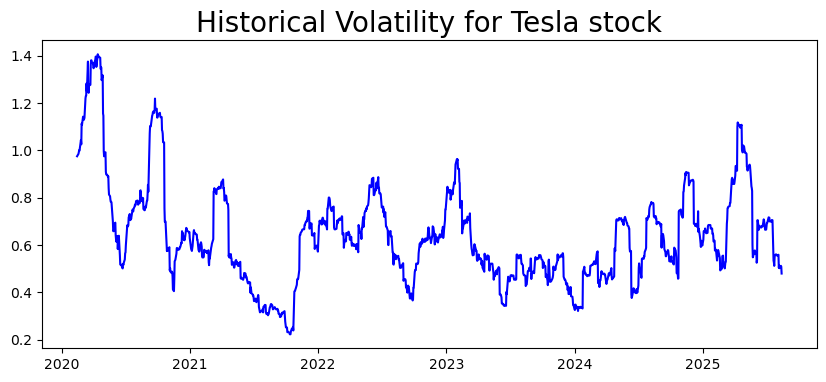

In [227]:
plt.figure(figsize=(10,4))
plt.plot(hist_vol, 'b')
plt.title('Historical Volatility for Tesla stock', fontsize=20)

Text(0.5, 1.0, 'Historical Log Returns for Tesla Stock')

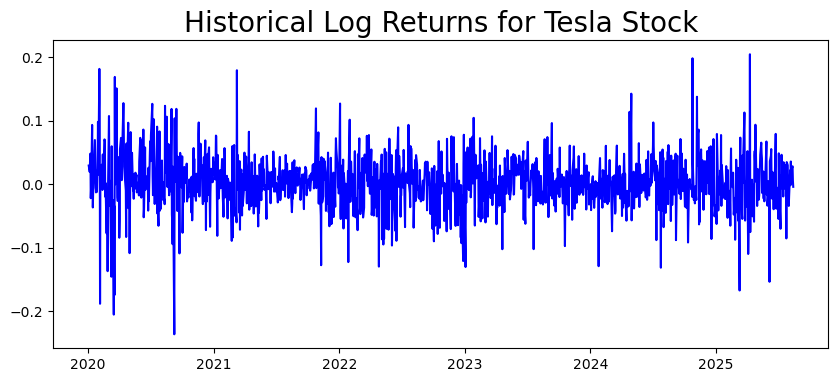

In [228]:
plt.figure(figsize=(10,4))
plt.plot(data["log_returns"], 'b')
plt.title('Historical Log Returns for Tesla Stock', fontsize=20)

## PACF plot

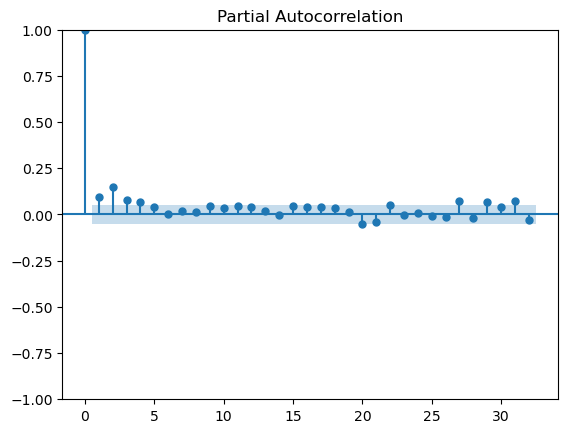

In [229]:
plot_pacf(np.array(data["log_returns"])**2)
plt.show()

## GARCH(p,q)

Try out some models here

In [276]:
model = arch_model(data["log_returns"], p=3, q=2)

In [277]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 2170035.059071041
Iteration:      2,   Func. Count:     22,   Neg. LLF: -2510.9808708287846
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2510.9808760464985
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


c:\Users\seand\anaconda3\envs\quant\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00181. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [278]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2510.98
Distribution:                  Normal   AIC:                          -5007.96
Method:            Maximum Likelihood   BIC:                          -4971.20
                                        No. Observations:                 1410
Date:                Thu, Aug 14 2025   Df Residuals:                     1409
Time:                        11:51:42   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.5288e-03  1.042e-03      1.468      0.142 [-5.125e-04,3.570e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.6209e-05  9.655e-06      3.750  1.766e-04  [1.729e-05,5.513e-05]
alpha[1]       0.0167  1.434e-02      1.162      0.245 [-1.145e-02,4.478e-02]
alpha[2]       0.0167  2.597e-02      0.642      0.521 [-3.423e-02,6.757e-02]
alpha[3]       0.0167  3.130e-02      0.532      0.594 [-4.469e-02,7.802e-02]
beta[1]        0.4650      0.361      1.289      0.197      [ -0.242,  1.172]
beta[2]        0.4650      0.349      1.331      0.183      [ -0.220,  1.150]
=============================================================================

Covariance estimator: robust
"""

GARCH(3,2) is probably not the best choice from the p values, but let's just stick with it.

## Rolling Forcast For Evaluation

In [279]:
rolling_predictions = []
test_size = 100
predictionHorizon = 10
numItterations = test_size//predictionHorizon + int(np.ceil(test_size/predictionHorizon - test_size//predictionHorizon).item())

for i in range(numItterations):
    train = data["log_returns"][:-(test_size)+i*predictionHorizon]
    model = arch_model(train *10 ,  p=3, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=predictionHorizon)
    rolling_predictions = rolling_predictions + (np.sqrt(pred.variance.values[-1, :]) *np.sqrt(252)/10).tolist()

In [280]:
rolling_predictions = pd.Series(rolling_predictions[:test_size], index=data.index[-test_size:])

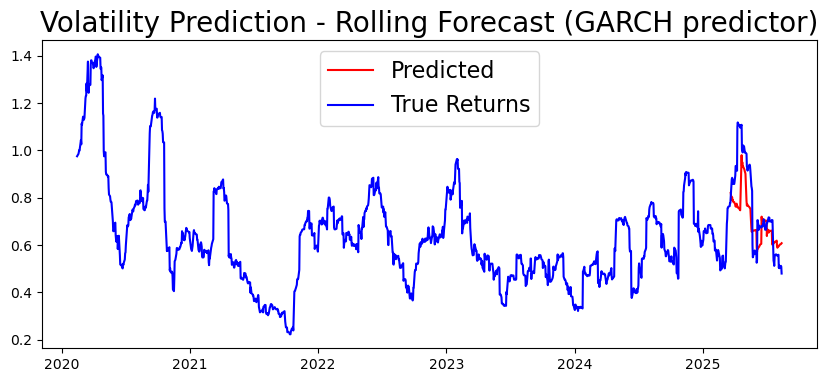

In [281]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions, 'r')
plt.plot(hist_vol, 'b')

plt.title('Volatility Prediction - Rolling Forecast (GARCH predictor)', fontsize=20)
plt.legend([ 'Predicted','True Returns'], fontsize=16)

In [282]:
np.linalg.norm(rolling_predictions.to_numpy() - hist_vol[-test_size:]) /test_size

np.float64(0.013313351575946033)

In [283]:
np.max(np.abs(rolling_predictions.to_numpy() - hist_vol[-test_size:])) 

np.float64(0.35955770754276617)

## Naive Predictor where we set the volatility of today equal to the volatility of the next few days

In [284]:
rolling_predictions_Naive = []
test_size = 100
predictionHorizon = 10
numItterations = test_size//predictionHorizon + int(np.ceil(test_size/predictionHorizon - test_size//predictionHorizon).item())

for i in range(numItterations):
    train = hist_vol[:-(test_size)+i*predictionHorizon]
    predNaive = [train[-1].item()]*predictionHorizon
    rolling_predictions_Naive = rolling_predictions_Naive + predNaive

C:\Users\seand\AppData\Local\Temp\ipykernel_19816\3948807845.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predNaive = [train[-1].item()]*predictionHorizon


In [285]:
rolling_predictions_Naive = pd.Series(rolling_predictions_Naive[:test_size], index=data.index[-test_size:])

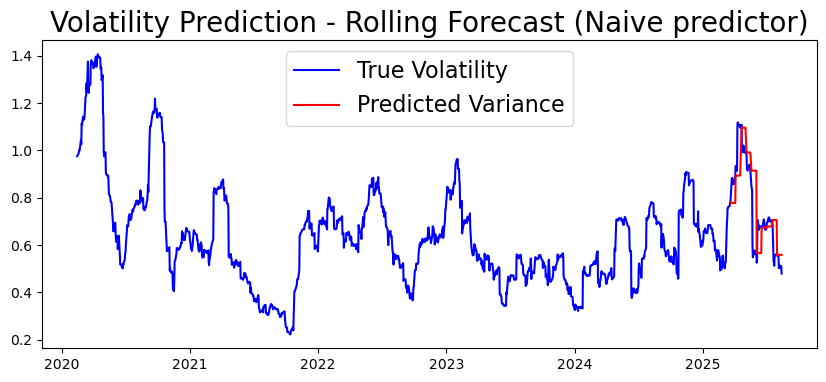

In [286]:
plt.figure(figsize=(10,4))
plt.plot(hist_vol, 'b')
preds, = plt.plot(rolling_predictions_Naive, "r")
plt.title('Volatility Prediction - Rolling Forecast (Naive predictor)', fontsize=20)
plt.legend(['True Volatility', 'Predicted Variance'], fontsize=16)

In [287]:
np.linalg.norm(rolling_predictions_Naive.to_numpy() - hist_vol[-test_size:])/test_size

np.float64(0.013121789727185479)

In [288]:
np.max(np.abs(rolling_predictions_Naive.to_numpy() - hist_vol[-test_size:]))

np.float64(0.3663353100857789)

#### Recap of what we did so far:

If you play around a little bit, then you can see that the GARCH model performs slightly better when predicting volatility with a larger horizon (measured with L2 and L infinity errors). However, it is important to say, that this is only one example, where this works, so it is hard to say, if this idea is really worth anything. And especially the p values from the summary indicate, that this is probably not significant and just overfited.

## Pricing Tesla Options under Black Scholes with predicted volatility

In [301]:
def naive_volatilityPredictor(data:np.array):
    return data.iloc[-1]

In [302]:
def GARCH_volatilityPredictor(data:np.array, horizon = 10):
    model = arch_model(train *10 ,  p=3, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=predictionHorizon).variance.values[0,:]
    pred = np.sqrt(pred) *np.sqrt(252)/10
    return np.mean(pred).item()

Text(0.5, 1.0, 'Historical Tesla Stock at Close')

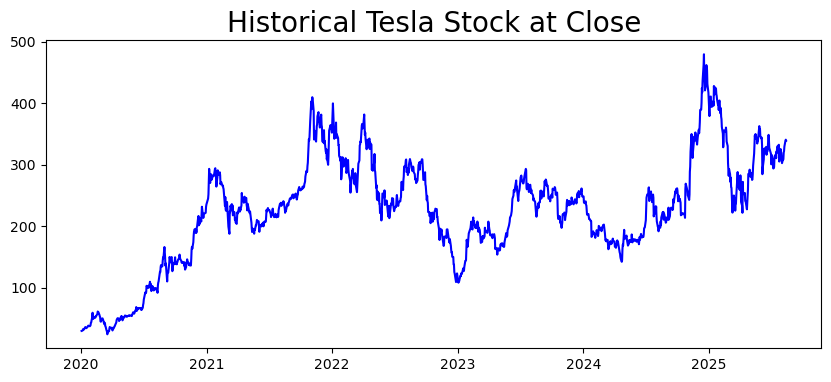

In [303]:
plt.figure(figsize=(10,4))
plt.plot(data["Close"], 'b')
plt.title('Historical Tesla Stock at Close', fontsize=20)

In [304]:
# Some data defining our option
# sigma has a higher impact on the BS pricing equation, when the horizon is large and when S/K is close to 1.
r = 0.05
t = 0
days = 100
T = days/252  
K = 400 # seems like a good choice for S/K close to 1


### Call

We focus on one european call option with maturity in 100 days. We want to know, what is the fair price. Black Scholes assumes a constant volatility and we want to know, if we can improve the price given by Black Scholes, if we plug in a "better" volatility, which is more representative for the entire horizon each day.

Let us plot the historical stock price:

In [305]:
naive_Volatility_BS_price_Call = []
GARCH_Volatility_BS_price_Call = []
for i in range(days):
    stockPrice = data["Close"].iloc[ -days + i]
    train = data["log_returns"][ :-days + i]
    hist_vol_train = hist_vol[:-days + i]
    sigma_GARCH = GARCH_volatilityPredictor(train, days - i)
    sigma_Naive =naive_volatilityPredictor(hist_vol_train)

    priceGARCH = analyticEuropeanCall(r,(t+i)/252,T,K,stockPrice,sigma_GARCH)
    priceNaive = analyticEuropeanCall(r,t+i/252,T,K,stockPrice,sigma_Naive)

    naive_Volatility_BS_price_Call.append(priceNaive)
    GARCH_Volatility_BS_price_Call.append(priceGARCH)

In [306]:
naive_Volatility_BS_price_Call = pd.Series(naive_Volatility_BS_price_Call, index=data.index[-days-1:-1])
GARCH_Volatility_BS_price_Call = pd.Series(GARCH_Volatility_BS_price_Call, index=data.index[-days-1:-1])

Text(0.5, 1.0, 'Call Option Price based on different Volatilities for Tesla stock')

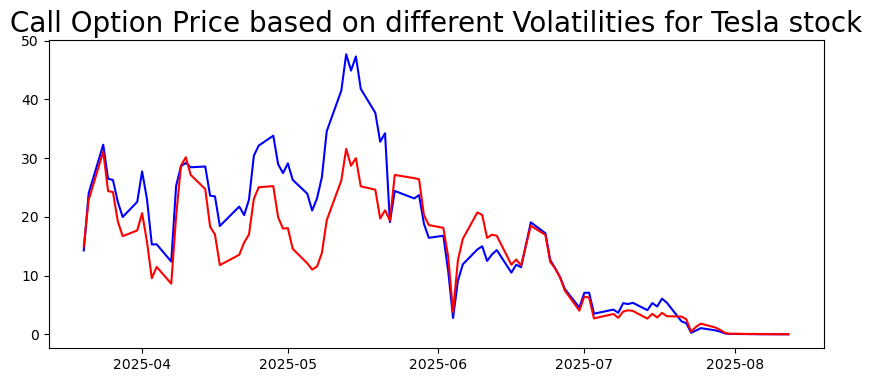

In [307]:
plt.figure(figsize=(10,4))
plt.plot(naive_Volatility_BS_price_Call, 'b')
plt.plot(GARCH_Volatility_BS_price_Call, 'r')
plt.title('Call Option Price based on different Volatilities for Tesla stock', fontsize=20)

In [308]:
print("The actual value of the option in the end was 0. So lets see which model did best on average.")
print(f"Mean option price based on GARCH           {np.mean(GARCH_Volatility_BS_price_Call).item()}")
print(f"Mean option price based on naive predictor {np.mean(naive_Volatility_BS_price_Call).item()}")

The actual value of the option in the end was 0. So lets see which model did best on average.
Mean option price based on GARCH           13.517027001946877
Mean option price based on naive predictor 16.562332759261157


The GARCH volatility seems to have done a better job, since its option price was more often under the naive approach!

### Put

We do the same for a put option now.

In [309]:
naive_Volatility_BS_price_Put = []
GARCH_Volatility_BS_price_Put = []
for i in range(days):
    stockPrice = data["Close"].iloc[ -days + i]
    train = data["log_returns"][ :-days + i]
    hist_vol_train = hist_vol[:-days + i]
    sigma_GARCH = GARCH_volatilityPredictor(train, days - i)
    sigma_Naive =naive_volatilityPredictor(hist_vol_train)

    priceGARCH = analyticEuropeanPut(r,(t+i)/252,T,K,stockPrice,sigma_GARCH)
    priceNaive = analyticEuropeanPut(r,t+i/252,T,K,stockPrice,sigma_Naive)

    naive_Volatility_BS_price_Put.append(priceNaive)
    GARCH_Volatility_BS_price_Put.append(priceGARCH)

In [310]:
naive_Volatility_BS_price_Put = pd.Series(naive_Volatility_BS_price_Put, index=data.index[-days-1:-1])
GARCH_Volatility_BS_price_Put = pd.Series(GARCH_Volatility_BS_price_Put, index=data.index[-days-1:-1])

Text(0.5, 1.0, 'Put Option Price based on different Volatilities for Tesla stock')

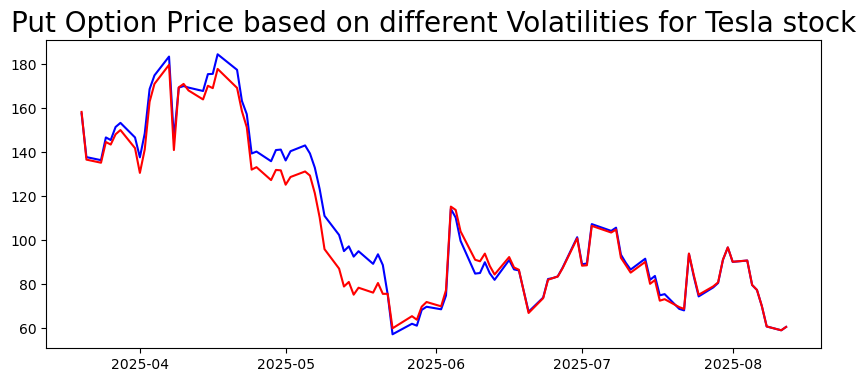

In [311]:
plt.figure(figsize=(10,4))
plt.plot(naive_Volatility_BS_price_Put, 'b')
plt.plot(GARCH_Volatility_BS_price_Put, 'r')
plt.title('Put Option Price based on different Volatilities for Tesla stock', fontsize=20)

In [312]:
print("The actual value of the option in the end was ~60. So lets see which model did best on average.")
print(f"Mean option price based on GARCH           {np.mean(GARCH_Volatility_BS_price_Put).item()}")
print(f"Mean option price based on naive predictor {np.mean(naive_Volatility_BS_price_Put).item()}")

The actual value of the option in the end was ~60. So lets see which model did best on average.
Mean option price based on GARCH           105.49879804354103
Mean option price based on naive predictor 108.54410380085532


Again, the GARCH model performed slightly better, since on average, it was closer to 60.